# Use Multivariable Linear Regression on House-Price Predict

In [1]:
# Imports 
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
#from Ipython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)

pd.set_option('display.max_columns', None)
%matplotlib inline
#njobs = 4

In [25]:
# Get data
train = pd.read_csv("./train.csv")
print("train : " + str(train.shape))

train : (1460, 81)


In [26]:
# Check for duplicates 
idsUnique = len(set(train.Id))
idsTotal = train.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

# Drop Id column
train.drop("Id", axis = 1, inplace = True)

There are 0 duplicate IDs for 1460 total entries


#### Preprocessing

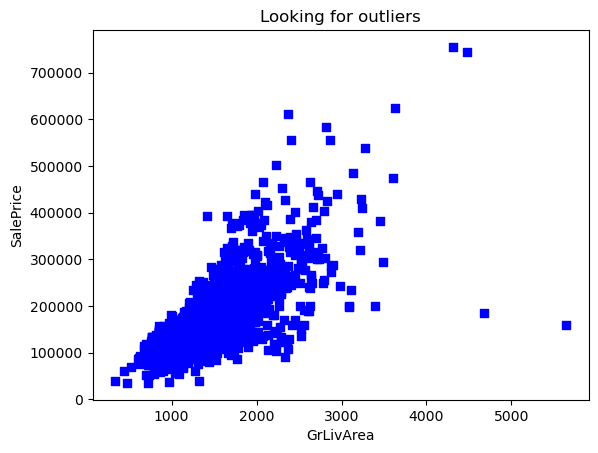

In [27]:
# Looking for outliers
plt.scatter(train.GrLivArea, train.SalePrice, c='b', marker='s')
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

train = train[train.GrLivArea < 4000]

There seems to be 2 extreme outliers on the bottom right, really large houses that sold for really cheap. More generally, the author of the dataset recommends removing 'any houses with more than 4000 square feet' from the dataset.
Reference : https://ww2.amstat.org/publications/jse/v19n3/decock.pdf

In [28]:
# Log transform the target for official scoring
train.SalePrice = np.log1p(train.SalePrice)
y = train.SalePrice

Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.

In [29]:

# Handle missing values for features where median/mean or most common value doesn't make sense

# Alley : data description says NA means "no alley access"
train.loc[:, "Alley"] = train.loc[:, "Alley"].fillna("None")
# BedroomAbvGr : NA most likely means 0
train.loc[:, "BedroomAbvGr"] = train.loc[:, "BedroomAbvGr"].fillna(0)
# BsmtQual etc : data description says NA for basement features is "no basement"
train.loc[:, "BsmtQual"] = train.loc[:, "BsmtQual"].fillna("No")
train.loc[:, "BsmtCond"] = train.loc[:, "BsmtCond"].fillna("No")
train.loc[:, "BsmtExposure"] = train.loc[:, "BsmtExposure"].fillna("No")
train.loc[:, "BsmtFinType1"] = train.loc[:, "BsmtFinType1"].fillna("No")
train.loc[:, "BsmtFinType2"] = train.loc[:, "BsmtFinType2"].fillna("No")
train.loc[:, "BsmtFullBath"] = train.loc[:, "BsmtFullBath"].fillna(0)
train.loc[:, "BsmtHalfBath"] = train.loc[:, "BsmtHalfBath"].fillna(0)
train.loc[:, "BsmtUnfSF"] = train.loc[:, "BsmtUnfSF"].fillna(0)
# CentralAir : NA most likely means No
train.loc[:, "CentralAir"] = train.loc[:, "CentralAir"].fillna("N")
# Condition : NA most likely means Normal
train.loc[:, "Condition1"] = train.loc[:, "Condition1"].fillna("Norm")
train.loc[:, "Condition2"] = train.loc[:, "Condition2"].fillna("Norm")
# EnclosedPorch : NA most likely means no enclosed porch
train.loc[:, "EnclosedPorch"] = train.loc[:, "EnclosedPorch"].fillna(0)
# External stuff : NA most likely means average
train.loc[:, "ExterCond"] = train.loc[:, "ExterCond"].fillna("TA")
train.loc[:, "ExterQual"] = train.loc[:, "ExterQual"].fillna("TA")
# Fence : data description says NA means "no fence"
train.loc[:, "Fence"] = train.loc[:, "Fence"].fillna("No")
# FireplaceQu : data description says NA means "no fireplace"
train.loc[:, "FireplaceQu"] = train.loc[:, "FireplaceQu"].fillna("No")
train.loc[:, "Fireplaces"] = train.loc[:, "Fireplaces"].fillna(0)
# Functional : data description says NA means typical
train.loc[:, "Functional"] = train.loc[:, "Functional"].fillna("Typ")
# GarageType etc : data description says NA for garage features is "no garage"
train.loc[:, "GarageType"] = train.loc[:, "GarageType"].fillna("No")
train.loc[:, "GarageFinish"] = train.loc[:, "GarageFinish"].fillna("No")
train.loc[:, "GarageQual"] = train.loc[:, "GarageQual"].fillna("No")
train.loc[:, "GarageCond"] = train.loc[:, "GarageCond"].fillna("No")
train.loc[:, "GarageArea"] = train.loc[:, "GarageArea"].fillna(0)
train.loc[:, "GarageCars"] = train.loc[:, "GarageCars"].fillna(0)
# HalfBath : NA most likely means no half baths above grade
train.loc[:, "HalfBath"] = train.loc[:, "HalfBath"].fillna(0)
# HeatingQC : NA most likely means typical
train.loc[:, "HeatingQC"] = train.loc[:, "HeatingQC"].fillna("TA")
# KitchenAbvGr : NA most likely means 0
train.loc[:, "KitchenAbvGr"] = train.loc[:, "KitchenAbvGr"].fillna(0)
# KitchenQual : NA most likely means typical
train.loc[:, "KitchenQual"] = train.loc[:, "KitchenQual"].fillna("TA")
# LotFrontage : NA most likely means no lot frontage
train.loc[:, "LotFrontage"] = train.loc[:, "LotFrontage"].fillna(0)
# LotShape : NA most likely means regular
train.loc[:, "LotShape"] = train.loc[:, "LotShape"].fillna("Reg")
# MasVnrType : NA most likely means no veneer
train.loc[:, "MasVnrType"] = train.loc[:, "MasVnrType"].fillna("None")
train.loc[:, "MasVnrArea"] = train.loc[:, "MasVnrArea"].fillna(0)
# MiscFeature : data description says NA means "no misc feature"
train.loc[:, "MiscFeature"] = train.loc[:, "MiscFeature"].fillna("No")
train.loc[:, "MiscVal"] = train.loc[:, "MiscVal"].fillna(0)
# OpenPorchSF : NA most likely means no open porch
train.loc[:, "OpenPorchSF"] = train.loc[:, "OpenPorchSF"].fillna(0)
# PavedDrive : NA most likely means not paved
train.loc[:, "PavedDrive"] = train.loc[:, "PavedDrive"].fillna("N")
# PoolQC : data description says NA means "no pool"
train.loc[:, "PoolQC"] = train.loc[:, "PoolQC"].fillna("No")
train.loc[:, "PoolArea"] = train.loc[:, "PoolArea"].fillna(0)
# SaleCondition : NA most likely means normal sale
train.loc[:, "SaleCondition"] = train.loc[:, "SaleCondition"].fillna("Normal")
# ScreenPorch : NA most likely means no screen porch
train.loc[:, "ScreenPorch"] = train.loc[:, "ScreenPorch"].fillna(0)
# TotRmsAbvGrd : NA most likely means 0
train.loc[:, "TotRmsAbvGrd"] = train.loc[:, "TotRmsAbvGrd"].fillna(0)
# Utilities : NA most likely means all public utilities
train.loc[:, "Utilities"] = train.loc[:, "Utilities"].fillna("AllPub")
# WoodDeckSF : NA most likely means no wood deck
train.loc[:, "WoodDeckSF"] = train.loc[:, "WoodDeckSF"].fillna(0)

In [30]:
#Some numerical features are actually really categories
train = train.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })


In [31]:
# Encode some categorical features as ordered numbers when there is information in the order
train = train.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

Then we will create new features, in 3 ways :

1. Simplifications of existing features
2. Combinations of existing features
3. Polynomials on the top 10 existing features

In [32]:
# Create new features
# 1* Simplifications of existing features
train["SimplOverallQual"] = train.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
train["SimplOverallCond"] = train.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
train["SimplPoolQC"] = train.PoolQC.replace({1 : 1, 2 : 1, # average
                                             3 : 2, 4 : 2 # good
                                            })
train["SimplGarageCond"] = train.GarageCond.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
train["SimplGarageQual"] = train.GarageQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplFunctional"] = train.Functional.replace({1 : 1, 2 : 1, # bad
                                                     3 : 2, 4 : 2, # major
                                                     5 : 3, 6 : 3, 7 : 3, # minor
                                                     8 : 4 # typical
                                                    })
train["SimplKitchenQual"] = train.KitchenQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplHeatingQC"] = train.HeatingQC.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
train["SimplBsmtFinType1"] = train.BsmtFinType1.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
train["SimplBsmtFinType2"] = train.BsmtFinType2.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
train["SimplBsmtCond"] = train.BsmtCond.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
train["SimplBsmtQual"] = train.BsmtQual.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
train["SimplExterCond"] = train.ExterCond.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
train["SimplExterQual"] = train.ExterQual.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })

# 2* Combinations of existing features
# Overall quality of the house
train["OverallGrade"] = train["OverallQual"] * train["OverallCond"]
# Overall quality of the garage
train["GarageGrade"] = train["GarageQual"] * train["GarageCond"]
# Overall quality of the exterior
train["ExterGrade"] = train["ExterQual"] * train["ExterCond"]
# Overall kitchen score
train["KitchenScore"] = train["KitchenAbvGr"] * train["KitchenQual"]
# Overall fireplace score
train["FireplaceScore"] = train["Fireplaces"] * train["FireplaceQu"]
# Overall garage score
train["GarageScore"] = train["GarageArea"] * train["GarageQual"]
# Overall pool score
train["PoolScore"] = train["PoolArea"] * train["PoolQC"]
# Simplified overall quality of the house
train["SimplOverallGrade"] = train["SimplOverallQual"] * train["SimplOverallCond"]
# Simplified overall quality of the exterior
train["SimplExterGrade"] = train["SimplExterQual"] * train["SimplExterCond"]
# Simplified overall pool score
train["SimplPoolScore"] = train["PoolArea"] * train["SimplPoolQC"]
# Simplified overall garage score
train["SimplGarageScore"] = train["GarageArea"] * train["SimplGarageQual"]
# Simplified overall fireplace score
train["SimplFireplaceScore"] = train["Fireplaces"] * train["SimplFireplaceQu"]
# Simplified overall kitchen score
train["SimplKitchenScore"] = train["KitchenAbvGr"] * train["SimplKitchenQual"]
# Total number of bathrooms
train["TotalBath"] = train["BsmtFullBath"] + (0.5 * train["BsmtHalfBath"]) + \
train["FullBath"] + (0.5 * train["HalfBath"])
# Total SF for house (incl. basement)
train["AllSF"] = train["GrLivArea"] + train["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
train["AllFlrsSF"] = train["1stFlrSF"] + train["2ndFlrSF"]
# Total SF for porch
train["AllPorchSF"] = train["OpenPorchSF"] + train["EnclosedPorch"] + \
train["3SsnPorch"] + train["ScreenPorch"]
# Has masonry veneer or not
train["HasMasVnr"] = train.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                               "Stone" : 1, "None" : 0})
# House completed before sale or not
train["BoughtOffPlan"] = train.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})

In [33]:
# Find most important features relative to target
print("Find most important features relative to target")
corr = train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Find most important features relative to target
SalePrice         1.000
OverallQual       0.819
AllSF             0.817
AllFlrsSF         0.729
GrLivArea         0.719
                  ...  
LandSlope        -0.040
SimplExterCond   -0.042
KitchenAbvGr     -0.148
EnclosedPorch    -0.149
LotShape         -0.286
Name: SalePrice, Length: 88, dtype: float64


/var/folders/k0/sqlrb6tx7w77mv29j7333kyh0000gq/T/ipykernel_19425/514482625.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train.corr()


In [34]:
# Create new features
# 3* Polynomials on the top 10 existing features
train["OverallQual-s2"] = train["OverallQual"] ** 2
train["OverallQual-s3"] = train["OverallQual"] ** 3
train["OverallQual-Sq"] = np.sqrt(train["OverallQual"])
train["AllSF-2"] = train["AllSF"] ** 2
train["AllSF-3"] = train["AllSF"] ** 3
train["AllSF-Sq"] = np.sqrt(train["AllSF"])
train["AllFlrsSF-2"] = train["AllFlrsSF"] ** 2
train["AllFlrsSF-3"] = train["AllFlrsSF"] ** 3
train["AllFlrsSF-Sq"] = np.sqrt(train["AllFlrsSF"])
train["GrLivArea-2"] = train["GrLivArea"] ** 2
train["GrLivArea-3"] = train["GrLivArea"] ** 3
train["GrLivArea-Sq"] = np.sqrt(train["GrLivArea"])
train["SimplOverallQual-s2"] = train["SimplOverallQual"] ** 2
train["SimplOverallQual-s3"] = train["SimplOverallQual"] ** 3
train["SimplOverallQual-Sq"] = np.sqrt(train["SimplOverallQual"])
train["ExterQual-2"] = train["ExterQual"] ** 2
train["ExterQual-3"] = train["ExterQual"] ** 3
train["ExterQual-Sq"] = np.sqrt(train["ExterQual"])
train["GarageCars-2"] = train["GarageCars"] ** 2
train["GarageCars-3"] = train["GarageCars"] ** 3
train["GarageCars-Sq"] = np.sqrt(train["GarageCars"])
train["TotalBath-2"] = train["TotalBath"] ** 2
train["TotalBath-3"] = train["TotalBath"] ** 3
train["TotalBath-Sq"] = np.sqrt(train["TotalBath"])
train["KitchenQual-2"] = train["KitchenQual"] ** 2
train["KitchenQual-3"] = train["KitchenQual"] ** 3
train["KitchenQual-Sq"] = np.sqrt(train["KitchenQual"])
train["GarageScore-2"] = train["GarageScore"] ** 2
train["GarageScore-3"] = train["GarageScore"] ** 3
train["GarageScore-Sq"] = np.sqrt(train["GarageScore"])

In [35]:
train 

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,GarageCars-Sq,TotalBath-2,TotalBath-3,TotalBath-Sq,KitchenQual-2,KitchenQual-3,KitchenQual-Sq,GarageScore-2,GarageScore-3,GarageScore-Sq
0,SC60,RL,65.000,8450,2,None,4,Lvl,4,Inside,...,1.414,12.250,42.875,1.871,16,64,2.000,2702736,4443297984,40.546
1,SC20,RL,80.000,9600,2,None,4,Lvl,4,FR2,...,1.414,6.250,15.625,1.581,9,27,1.732,1904400,2628072000,37.148
2,SC60,RL,68.000,11250,2,None,3,Lvl,4,Inside,...,1.414,12.250,42.875,1.871,16,64,2.000,3326976,6068404224,42.708
3,SC70,RL,60.000,9550,2,None,3,Lvl,4,Corner,...,1.732,4.000,8.000,1.414,16,64,2.000,3709476,7144450776,43.886
4,SC60,RL,84.000,14260,2,None,3,Lvl,4,FR2,...,1.732,12.250,42.875,1.871,16,64,2.000,6290064,15775480512,50.080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,SC60,RL,62.000,7917,2,None,4,Lvl,4,Inside,...,1.414,6.250,15.625,1.581,9,27,1.732,1904400,2628072000,37.148
1456,SC20,RL,85.000,13175,2,None,4,Lvl,4,Inside,...,1.414,9.000,27.000,1.732,9,27,1.732,2250000,3375000000,38.730
1457,SC70,RL,66.000,9042,2,None,4,Lvl,4,Inside,...,1.000,4.000,8.000,1.414,16,64,2.000,571536,432081216,27.495
1458,SC20,RL,68.000,9717,2,None,4,Lvl,4,Inside,...,1.000,4.000,8.000,1.414,16,64,2.000,518400,373248000,26.833


In [36]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = train.select_dtypes(include = ["object"]).columns
numerical_features = train.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("SalePrice")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
train_num = train[numerical_features]
train_cat = train[categorical_features]

Numerical features : 117
Categorical features : 26


In [37]:
# Handle remaining missing values for numerical features by using median as replacement
print("NAs for numerical features in train : " + str(train_num.isnull().values.sum()))
train_num = train_num.fillna(train_num.median())
print("Remaining NAs for numerical features in train : " + str(train_num.isnull().values.sum()))

NAs for numerical features in train : 81
Remaining NAs for numerical features in train : 0


In [38]:
# Log transform of the skewed numerical features to lessen impact of outliers
# Inspired by Alexandru Papiu's script : https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
skewness = train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
train_num[skewed_features] = np.log1p(train_num[skewed_features])

86 skewed numerical features to log transform


In [39]:
skewness.index.tolist()

['LotArea',
 'Street',
 'LotShape',
 'Utilities',
 'LandSlope',
 'OverallCond',
 'YearBuilt',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'HeatingQC',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'HalfBath',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'GarageYrBlt',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'PoolQC',
 'MiscVal',
 'SimplOverallCond',
 'SimplPoolQC',
 'SimplGarageCond',
 'SimplGarageQual',
 'SimplFunctional',
 'SimplHeatingQC',
 'SimplBsmtFinType1',
 'SimplBsmtFinType2',
 'SimplBsmtCond',
 'SimplExterCond',
 'SimplExterQual',
 'GarageGrade',
 'ExterGrade',
 'KitchenScore',
 'FireplaceScore',
 'PoolScore',
 'SimplExterGrade',
 'SimplPoolScore',
 'SimplGarageScore',
 'SimplFireplaceScore',
 'AllSF',
 'AllFlrsS

In [43]:
train_cat.isnull().any()

MSSubClass       False
MSZoning         False
Alley            False
LandContour      False
LotConfig        False
Neighborhood     False
Condition1       False
Condition2       False
BldgType         False
HouseStyle       False
RoofStyle        False
RoofMatl         False
Exterior1st      False
Exterior2nd      False
MasVnrType       False
Foundation       False
Heating          False
CentralAir       False
Electrical        True
GarageType       False
GarageFinish     False
Fence            False
MiscFeature      False
MoSold           False
SaleType         False
SaleCondition    False
dtype: bool

In [21]:
# Create dummy features for categorical values via one-hot encoding
print("NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))
train_cat = pd.get_dummies(train_cat)
print("Remaining NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))


NAs for categorical features in train : 1
Remaining NAs for categorical features in train : 0


,MSSubClass,MSZoning,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,Electrical,GarageType,GarageFinish,Fence,MiscFeature,MoSold,SaleType,SaleCondition
0,SC60,RL,None,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,SBrkr,Attchd,RFn,No,No,Feb,WD,Normal
1,SC20,RL,None,Lvl,FR2,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,CBlock,GasA,Y,SBrkr,Attchd,RFn,No,No,May,WD,Normal
2,SC60,RL,None,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,SBrkr,Attchd,RFn,No,No,Sep,WD,Normal
3,SC70,RL,None,Lvl,Corner,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,BrkTil,GasA,Y,SBrkr,Detchd,Unf,No,No,Feb,WD,Abnorml
4,SC60,RL,None,Lvl,FR2,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,SBrkr,Attchd,RFn,No,No,Dec,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,SC60,RL,None,Lvl,Inside,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,PConc,GasA,Y,SBrkr,Attchd,RFn,No,No,Aug,WD,Normal
1456,SC20,RL,None,Lvl,Inside,NWAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,Plywood,Plywood,Stone,CBlock,GasA,Y,SBrkr,Attchd,Unf,MnPrv,No,Feb,WD,Normal
1457,SC70,RL,None,Lvl,Inside,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,CemntBd,CmentBd,None,Stone,GasA,Y,SBrkr,Attchd,RFn,GdPrv,Shed,May,WD,Normal
1458,SC20,RL,None,Lvl,Inside,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,MetalSd,MetalSd,None,CBlock,GasA,Y,FuseA,Attchd,Unf,No,No,Apr,WD,Normal


### Modeling

In [46]:
# Join categorical and numerial features
train = pd.concat([train_num, train_cat], axis = 1)
print("New number of features: " + str(train.shape[1]))

# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3,random_state=0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))


New number of features: 319
X_train : (1019, 319)
X_test : (437, 319)
y_train : (1019,)
y_test : (437,)


In [86]:
train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SimplOverallQual,SimplOverallCond,SimplPoolQC,SimplGarageCond,SimplGarageQual,SimplFireplaceQu,SimplFunctional,SimplKitchenQual,SimplHeatingQC,SimplBsmtFinType1,SimplBsmtFinType2,SimplBsmtCond,SimplBsmtQual,SimplExterCond,SimplExterQual,OverallGrade,GarageGrade,ExterGrade,KitchenScore,FireplaceScore,GarageScore,PoolScore,SimplOverallGrade,SimplExterGrade,SimplPoolScore,SimplGarageScore,SimplFireplaceScore,SimplKitchenScore,TotalBath,AllSF,AllFlrsSF,AllPorchSF,HasMasVnr,BoughtOffPlan,OverallQual-s2,OverallQual-s3,OverallQual-Sq,AllSF-2,AllSF-3,AllSF-Sq,AllFlrsSF-2,AllFlrsSF-3,AllFlrsSF-Sq,GrLivArea-2,GrLivArea-3,GrLivArea-Sq,SimplOverallQual-s2,SimplOverallQual-s3,SimplOverallQual-Sq,ExterQual-2,ExterQual-3,ExterQual-Sq,GarageCars-2,GarageCars-3,GarageCars-Sq,TotalBath-2,TotalBath-3,TotalBath-Sq,KitchenQual-2,KitchenQual-3,KitchenQual-Sq,GarageScore-2,GarageScore-3,GarageScore-Sq
0,SC60,RL,65.000,8450,2,None,4,Lvl,4,Inside,3,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,4,3,PConc,4,3,0,6,706,1,0,150,856,GasA,5,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,4,8,8,0,0,Attchd,2003.000,RFn,2,548,3,3,2,0,61,0,0,0,0,0,No,No,0,Feb,2008,WD,Normal,12.248,3,2,0,1,1,0,4,2,2,2,1,1,2,1,2,35,9,12,4,0,1644,0,6,2,0,548,0,2,3.500,2566,1710,61,1,0,49,343,2.646,6584356,16895457496,50.656,2924100,5000211000,41.352,2924100,5000211000,41.352,9,27,1.732,16,64,2.000,4,8,1.414,12.250,42.875,1.871,16,64,2.000,2702736,4443297984,40.546
1,SC20,RL,80.000,9600,2,None,4,Lvl,4,FR2,3,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,3,3,CBlock,4,3,3,5,978,1,0,284,1262,GasA,5,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,3,6,8,1,3,Attchd,1976.000,RFn,2,460,3,3,2,298,0,0,0,0,0,0,No,No,0,May,2007,WD,Normal,12.109,2,3,0,1,1,1,4,1,2,2,1,1,2,1,1,48,9,9,3,3,1380,0,6,1,0,460,1,1,2.500,2524,1262,0,0,0,36,216,2.449,6370576,16079333824,50.239,1592644,2009916728,35.525,1592644,2009916728,35.525,4,8,1.414,9,27,1.732,4,8,1.414,6.250,15.625,1.581,9,27,1.732,1904400,2628072000,37.148
2,SC60,RL,68.000,11250,2,None,3,Lvl,4,Inside,3,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,4,3,PConc,4,3,1,6,486,1,0,434,920,GasA,5,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,4,6,8,1,3,Attchd,2001.000,RFn,2,608,3,3,2,0,42,0,0,0,0,0,No,No,0,Sep,2008,WD,Normal,12.317,3,2,0,1,1,1,4,2,2,2,1,1,2,1,2,35,9,12,4,3,1824,0,6,2,0,608,1,2,3.500,2706,1786,42,1,0,49,343,2.646,7322436,19814511816,52.019,3189796,5696975656,42.261,3189796,5696975656,42.261,9,27,1.732,16,64,2.000,4,8,1.414,12.250,42.875,1.871,16,64,2.000,3326976,6068404224,42.708
3,SC70,RL,60.000,9550,2,None,3,Lvl,4,Corner,3,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,3,3,BrkTil,3,4,0,5,216,1,0,540,756,GasA,4,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,4,7,8,1,4,Detchd,1998.000,Unf,3,642,3,3,2,0,35,272,0,0,0,0,No,No,0,Feb,2006,WD,Abnorml,11.849,3,2,0,1,1,2,4,2,2,2,1,2,1,1,1,35,9,9,4,4,1926,0,6,1,0,642,2,2,2.000,2473,1717,307,0,0,49,343,2.646,6115729,15124197817,49.729,2948089,5061868813,41.437,2948089,5061868813,41.437,9,27,1.732,9,27,1.732,9,27,1.732,4.000,8.000,1.414,16,64,2.000,370947

In [47]:
stdSc = StandardScaler()
X_train.loc[:, numerical_features] = stdSc.fit_transform(X_train.loc[:, numerical_features])
X_test.loc[:, numerical_features] = stdSc.transform(X_test.loc[:, numerical_features])

In [51]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

Note : I'm not getting nearly the same numbers in local CV compared to public LB, so I'm a tad worried that my CV process may have an issue somewhere. If you spot something, please let me know.

#### 1* Linear Regression without regularization

RMSE on Training set:  0.3889176582415743
RMSE on Test set : 242289886539.7544


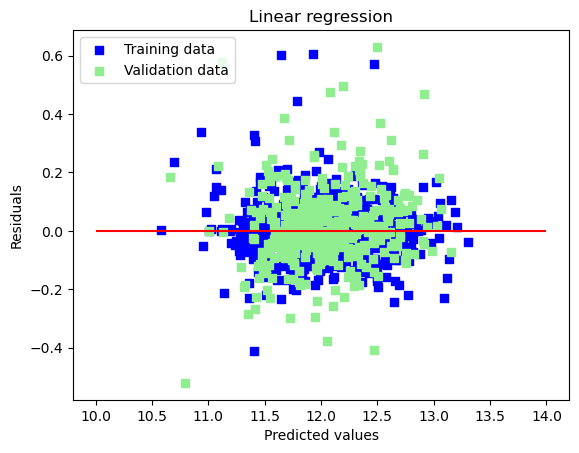

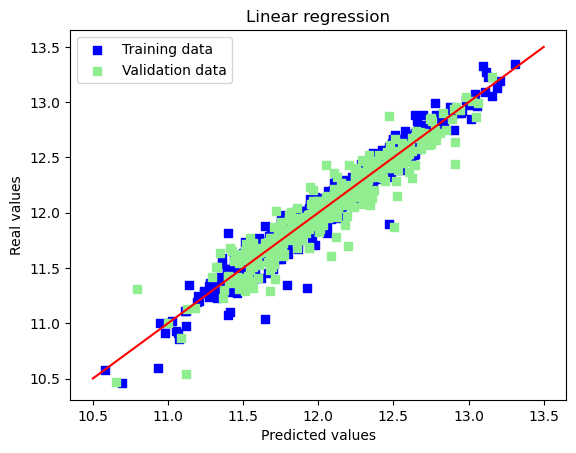

In [56]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Look at the predictions on training and validation set
print("RMSE on Training set: ", rmse_cv_train(lr).mean())
print("RMSE on Test set :",rmse_cv_test(lr).mean())
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Plot residuals 
plt.scatter(y_train_pred, y_train_pred - y_train, c='blue',marker='s',label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c= 'lightgreen',marker = 's',label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
#plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.hlines(y = 0, xmin = 10, xmax = 14, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

RMSE on Training set shows up weird here (not when I run it on my computer) for some reason.
**Errors seem randomly distributed and randomly scattered around the centerline, so there is that at least**. <u>It means our model was able to capture most of the explanatory information</u>.

#### 2. * Linear Regression with Ridge regularization (L2 penalty)

**Why we need regularization**

From the Python Machine Learning book by Sebastian Raschka : Regularization is a very useful method to **handle collinearity**, **filter out noise from data**, and eventually **prevent overfitting**. 

**Regularization in simple explanation**

The concept behind regularization is to introduce additional information (bias) to penalize extreme parameter weights.

**Ridge Regression** 

Ridge regression is an L2 penalized model where we simply add the squared sum of the weights to our cost function.

Best alpha : 30.0
Try again for more precision with alphas centered around 30.0
Best alpha : 24.0
Ridge RMSE on Training set : 0.11540572328450804
Ridge RMSE on Test set : 0.11642721377799567


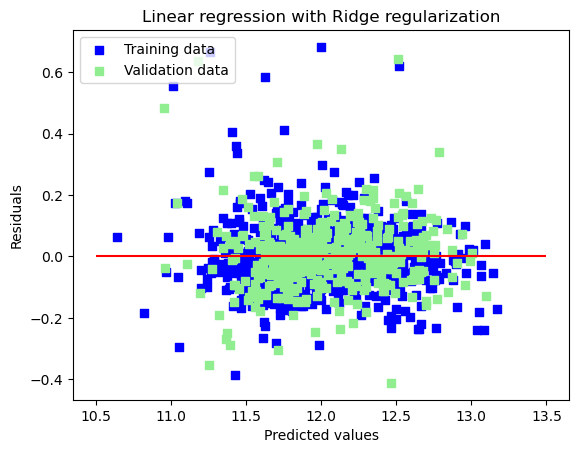

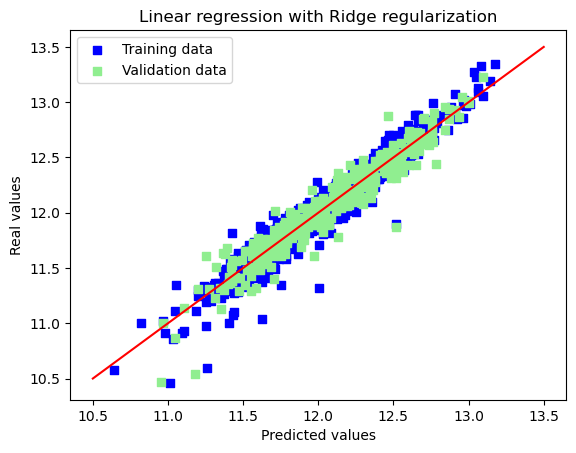

Ridge picked 316 features and eliminated the other 3 features


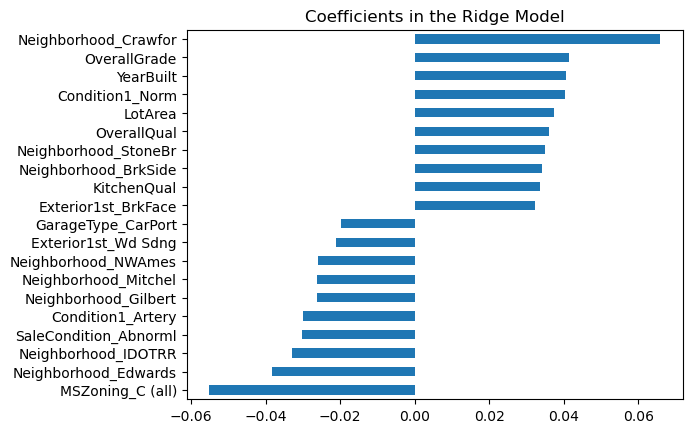

In [61]:
# 2* Ridge
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())
y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)

# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()



See ridge regression at:https://www.youtube.com/watch?v=Q81RR3yKn30

We're getting a much better RMSE result now that we've added regularization. The very small difference between training and test results indicate that we eliminated most of the overfitting. Visually, the graphs seem to confirm that idea.

Ridge used almost all of the existing features.

#### 3* Linear Regression with Lasso regularization (L1 penalty)
#### 3* 带有Lasso正则化（L1惩罚项）的线性回归
**LASSO** stands for **Least Absolute Shrinkage and Selection Operator**. It is an alternative regularization method, where we simply replace the square of the weights by the sum of the absolute value of the weights. 

``**LASSO** 代表**最小绝对收缩和选择运算符**。这是一种替代的正则化方法，我们简单地用权重的绝对值之和替换权重的平方。``

**L1 penalty** In contrast to L2 regularization, L1 regularization yields sparse feature vectors : most feature weights will be zero. Sparsity can be useful in practice if we have a high dimensional dataset with many features that are irrelevant.

``**L1惩罚**与L2正则化相比，L1正则化产生稀疏的特征向量：大多数特征权重将为零。如果我们有一个具有许多无关特征的高维数据集，稀疏性在实践中可能是有用的。``

We can suspect that it should be more efficient than Ridge here.

``我们可以猜想，在这里使用Lasso应该比Ridge更有效。``






Best alpha : 0.0006
Try again for more precision with alphas centered around 0.0006
Best alpha : 0.0006
Lasso RMSE on Training set : 0.11411150837458062
Lasso RMSE on Test set : 0.1158321322175071


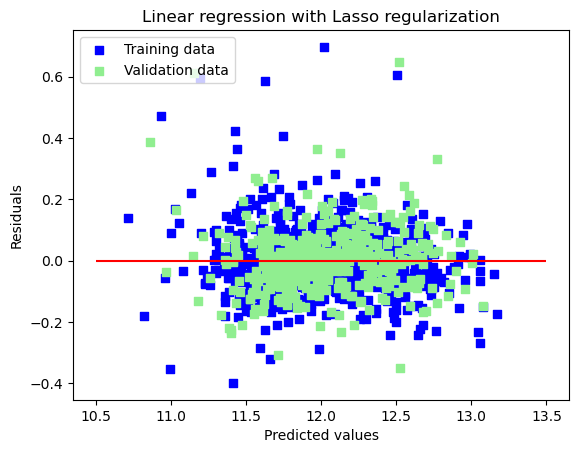

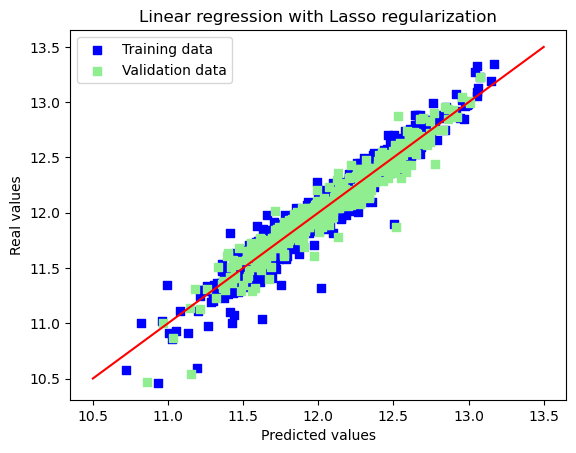

Lasso picked 111 features and eliminated the other 208 features


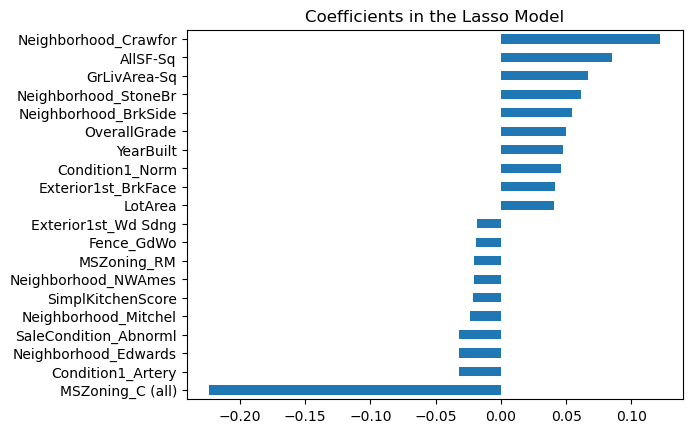

In [62]:
# 3* Lasso
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)

# Plot residuals
plt.scatter(y_train_las, y_train_las - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

RMSE results are better both on training and test sets. The most interesting thing is that Lasso used only one third of the available features. Another interesting tidbit : it seems to give big weights to Neighborhood categories, both in positive and negative ways. Intuitively it makes sense, house prices change a whole lot from one neighborhood to another in the same city.

The `"MSZoning_C (all)"` feature seems to have a disproportionate impact compared to the others. It is defined as general zoning classification : commercial. It seems a bit weird to me that having your house in a mostly commercial zone would be such a terrible thing.

#### 4* Linear Regression with ElasticNet regularization (L1 and L2 penalty)

ElasticNet is a compromise between Ridge and Lasso regression. It has a L1 penalty to generate sparsity and a L2 penalty to overcome some of the limitations of Lasso, such as the number of variables (Lasso can't select more features than it has observations, but it's not the case here anyway).

In [63]:
# 4* ElasticNet
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

/Users/walterwu/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05083180854244418, tolerance: 0.014269102454300513
  model = cd_fast.enet_coordinate_descent_gram(
/Users/walterwu/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04478905963636848, tolerance: 0.014439328514818332
  model = cd_fast.enet_coordinate_descent_gram(


Best l1_ratio : 1.0
Best alpha : 0.0006


In [64]:
print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

Try again for more precision with l1_ratio centered around 1.0
Best l1_ratio : 1.0
Best alpha : 0.0006


In [65]:
print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

Now try again for more precision on alpha, with l1_ratio fixed at 1.0 and alpha centered around 0.0006
Best l1_ratio : 1.0
Best alpha : 0.0006


In [67]:
print("ElasticNet RMSE on Training set :", rmse_cv_train(elasticNet).mean())
print("ElasticNet RMSE on Test set :", rmse_cv_test(elasticNet).mean())
y_train_ela = elasticNet.predict(X_train)
y_test_ela = elasticNet.predict(X_test)

ElasticNet RMSE on Training set : 0.11411150837458062
ElasticNet RMSE on Test set : 0.1158321322175071


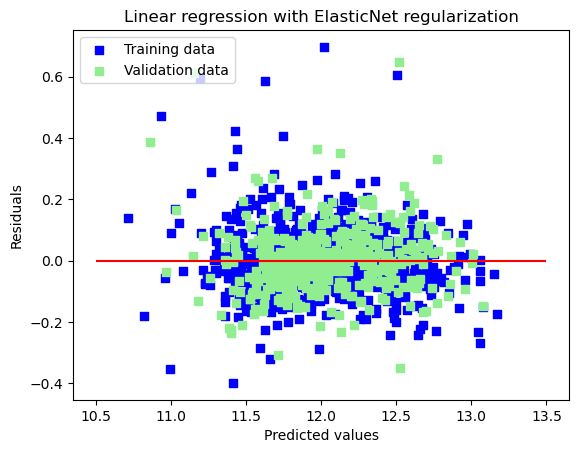

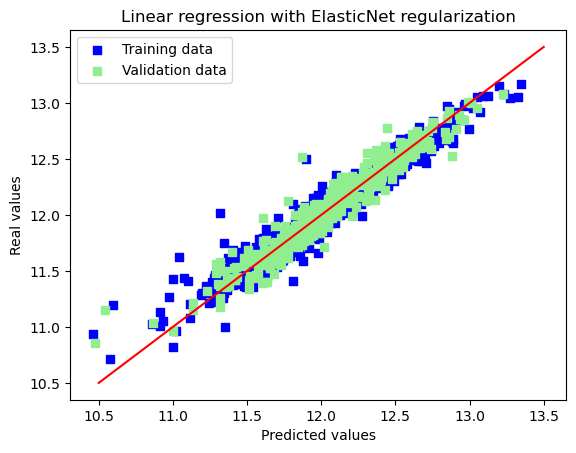

ElasticNet picked 111 features and eliminated the other 208 features


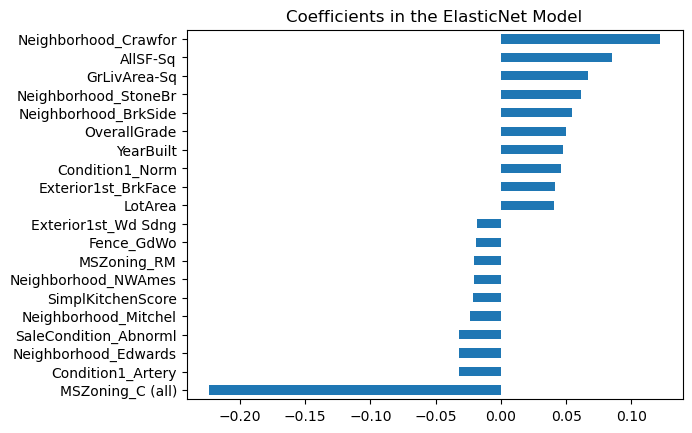

In [68]:
# Plot residuals
plt.scatter(y_train_ela, y_train_ela - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ela, y_test_ela - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train, y_train_ela, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test, y_test_ela, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(elasticNet.coef_, index = X_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()

####  Submission_Lasso

In [46]:
def clone_preprocess(train):
    # 1. Handle missing values for features where median/mean or most common value doesn't make sense
    # Alley : data description says NA means "no alley access"
    train.loc[:, "Alley"] = train.loc[:, "Alley"].fillna("None")
    # BedroomAbvGr : NA most likely means 0
    train.loc[:, "BedroomAbvGr"] = train.loc[:, "BedroomAbvGr"].fillna(0)
    # BsmtQual etc : data description says NA for basement features is "no basement"
    train.loc[:, "BsmtQual"] = train.loc[:, "BsmtQual"].fillna("No")
    train.loc[:, "BsmtCond"] = train.loc[:, "BsmtCond"].fillna("No")
    train.loc[:, "BsmtExposure"] = train.loc[:, "BsmtExposure"].fillna("No")
    train.loc[:, "BsmtFinType1"] = train.loc[:, "BsmtFinType1"].fillna("No")
    train.loc[:, "BsmtFinType2"] = train.loc[:, "BsmtFinType2"].fillna("No")
    train.loc[:, "BsmtFullBath"] = train.loc[:, "BsmtFullBath"].fillna(0)
    train.loc[:, "BsmtHalfBath"] = train.loc[:, "BsmtHalfBath"].fillna(0)
    train.loc[:, "BsmtUnfSF"] = train.loc[:, "BsmtUnfSF"].fillna(0)
    # CentralAir : NA most likely means No
    train.loc[:, "CentralAir"] = train.loc[:, "CentralAir"].fillna("N")
    # Condition : NA most likely means Normal
    train.loc[:, "Condition1"] = train.loc[:, "Condition1"].fillna("Norm")
    train.loc[:, "Condition2"] = train.loc[:, "Condition2"].fillna("Norm")
    # EnclosedPorch : NA most likely means no enclosed porch
    train.loc[:, "EnclosedPorch"] = train.loc[:, "EnclosedPorch"].fillna(0)
    # External stuff : NA most likely means average
    train.loc[:, "ExterCond"] = train.loc[:, "ExterCond"].fillna("TA")
    train.loc[:, "ExterQual"] = train.loc[:, "ExterQual"].fillna("TA")
    # Fence : data description says NA means "no fence"
    train.loc[:, "Fence"] = train.loc[:, "Fence"].fillna("No")
    # FireplaceQu : data description says NA means "no fireplace"
    train.loc[:, "FireplaceQu"] = train.loc[:, "FireplaceQu"].fillna("No")
    train.loc[:, "Fireplaces"] = train.loc[:, "Fireplaces"].fillna(0)
    # Functional : data description says NA means typical
    train.loc[:, "Functional"] = train.loc[:, "Functional"].fillna("Typ")
    # GarageType etc : data description says NA for garage features is "no garage"
    train.loc[:, "GarageType"] = train.loc[:, "GarageType"].fillna("No")
    train.loc[:, "GarageFinish"] = train.loc[:, "GarageFinish"].fillna("No")
    train.loc[:, "GarageQual"] = train.loc[:, "GarageQual"].fillna("No")
    train.loc[:, "GarageCond"] = train.loc[:, "GarageCond"].fillna("No")
    train.loc[:, "GarageArea"] = train.loc[:, "GarageArea"].fillna(0)
    train.loc[:, "GarageCars"] = train.loc[:, "GarageCars"].fillna(0)
    # HalfBath : NA most likely means no half baths above grade
    train.loc[:, "HalfBath"] = train.loc[:, "HalfBath"].fillna(0)
    # HeatingQC : NA most likely means typical
    train.loc[:, "HeatingQC"] = train.loc[:, "HeatingQC"].fillna("TA")
    # KitchenAbvGr : NA most likely means 0
    train.loc[:, "KitchenAbvGr"] = train.loc[:, "KitchenAbvGr"].fillna(0)
    # KitchenQual : NA most likely means typical
    train.loc[:, "KitchenQual"] = train.loc[:, "KitchenQual"].fillna("TA")
    # LotFrontage : NA most likely means no lot frontage
    train.loc[:, "LotFrontage"] = train.loc[:, "LotFrontage"].fillna(0)
    # LotShape : NA most likely means regular
    train.loc[:, "LotShape"] = train.loc[:, "LotShape"].fillna("Reg")
    # MasVnrType : NA most likely means no veneer
    train.loc[:, "MasVnrType"] = train.loc[:, "MasVnrType"].fillna("None")
    train.loc[:, "MasVnrArea"] = train.loc[:, "MasVnrArea"].fillna(0)
    # MiscFeature : data description says NA means "no misc feature"
    train.loc[:, "MiscFeature"] = train.loc[:, "MiscFeature"].fillna("No")
    train.loc[:, "MiscVal"] = train.loc[:, "MiscVal"].fillna(0)
    # OpenPorchSF : NA most likely means no open porch
    train.loc[:, "OpenPorchSF"] = train.loc[:, "OpenPorchSF"].fillna(0)
    # PavedDrive : NA most likely means not paved
    train.loc[:, "PavedDrive"] = train.loc[:, "PavedDrive"].fillna("N")
    # PoolQC : data description says NA means "no pool"
    train.loc[:, "PoolQC"] = train.loc[:, "PoolQC"].fillna("No")
    train.loc[:, "PoolArea"] = train.loc[:, "PoolArea"].fillna(0)
    # SaleCondition : NA most likely means normal sale
    train.loc[:, "SaleCondition"] = train.loc[:, "SaleCondition"].fillna("Normal")
    # ScreenPorch : NA most likely means no screen porch
    train.loc[:, "ScreenPorch"] = train.loc[:, "ScreenPorch"].fillna(0)
    # TotRmsAbvGrd : NA most likely means 0
    train.loc[:, "TotRmsAbvGrd"] = train.loc[:, "TotRmsAbvGrd"].fillna(0)
    # Utilities : NA most likely means all public utilities
    train.loc[:, "Utilities"] = train.loc[:, "Utilities"].fillna("AllPub")
    # WoodDeckSF : NA most likely means no wood deck
    train.loc[:, "WoodDeckSF"] = train.loc[:, "WoodDeckSF"].fillna(0)
    
    
    # 2. #Some numerical features are actually really categories
    train = train.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                           50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                           80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                           150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                           "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                       7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                          })
    #3. Encode some categorical features as ordered numbers when there is information in the order
    train = train.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                           "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                           "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                           "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                             "ALQ" : 5, "GLQ" : 6},
                           "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                             "ALQ" : 5, "GLQ" : 6},
                           "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                           "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                           "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                           "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                           "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                           "Min2" : 6, "Min1" : 7, "Typ" : 8},
                           "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                           "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                           "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                           "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                           "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                           "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                           "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                           "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                           "Street" : {"Grvl" : 1, "Pave" : 2},
                           "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                         )
    # 4. # Create new features
    # 1* Simplifications of existing features
    train["SimplOverallQual"] = train.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                           4 : 2, 5 : 2, 6 : 2, # average
                                                           7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                          })
    train["SimplOverallCond"] = train.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                           4 : 2, 5 : 2, 6 : 2, # average
                                                           7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                          })
    train["SimplPoolQC"] = train.PoolQC.replace({1 : 1, 2 : 1, # average
                                                 3 : 2, 4 : 2 # good
                                                })
    train["SimplGarageCond"] = train.GarageCond.replace({1 : 1, # bad
                                                         2 : 1, 3 : 1, # average
                                                         4 : 2, 5 : 2 # good
                                                        })
    train["SimplGarageQual"] = train.GarageQual.replace({1 : 1, # bad
                                                         2 : 1, 3 : 1, # average
                                                         4 : 2, 5 : 2 # good
                                                        })
    train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                           2 : 1, 3 : 1, # average
                                                           4 : 2, 5 : 2 # good
                                                          })
    train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                           2 : 1, 3 : 1, # average
                                                           4 : 2, 5 : 2 # good
                                                          })
    train["SimplFunctional"] = train.Functional.replace({1 : 1, 2 : 1, # bad
                                                         3 : 2, 4 : 2, # major
                                                         5 : 3, 6 : 3, 7 : 3, # minor
                                                         8 : 4 # typical
                                                        })
    train["SimplKitchenQual"] = train.KitchenQual.replace({1 : 1, # bad
                                                           2 : 1, 3 : 1, # average
                                                           4 : 2, 5 : 2 # good
                                                          })
    train["SimplHeatingQC"] = train.HeatingQC.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
    train["SimplBsmtFinType1"] = train.BsmtFinType1.replace({1 : 1, # unfinished
                                                             2 : 1, 3 : 1, # rec room
                                                             4 : 2, 5 : 2, 6 : 2 # living quarters
                                                            })
    train["SimplBsmtFinType2"] = train.BsmtFinType2.replace({1 : 1, # unfinished
                                                             2 : 1, 3 : 1, # rec room
                                                             4 : 2, 5 : 2, 6 : 2 # living quarters
                                                            })
    train["SimplBsmtCond"] = train.BsmtCond.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
    train["SimplBsmtQual"] = train.BsmtQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
    train["SimplExterCond"] = train.ExterCond.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
    train["SimplExterQual"] = train.ExterQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })

    # 2* Combinations of existing features
    # Overall quality of the house
    train["OverallGrade"] = train["OverallQual"] * train["OverallCond"]
    # Overall quality of the garage
    train["GarageGrade"] = train["GarageQual"] * train["GarageCond"]
    # Overall quality of the exterior
    train["ExterGrade"] = train["ExterQual"] * train["ExterCond"]
    # Overall kitchen score
    train["KitchenScore"] = train["KitchenAbvGr"] * train["KitchenQual"]
    # Overall fireplace score
    train["FireplaceScore"] = train["Fireplaces"] * train["FireplaceQu"]
    # Overall garage score
    train["GarageScore"] = train["GarageArea"] * train["GarageQual"]
    # Overall pool score
    train["PoolScore"] = train["PoolArea"] * train["PoolQC"]
    # Simplified overall quality of the house
    train["SimplOverallGrade"] = train["SimplOverallQual"] * train["SimplOverallCond"]
    # Simplified overall quality of the exterior
    train["SimplExterGrade"] = train["SimplExterQual"] * train["SimplExterCond"]
    # Simplified overall pool score
    train["SimplPoolScore"] = train["PoolArea"] * train["SimplPoolQC"]
    # Simplified overall garage score
    train["SimplGarageScore"] = train["GarageArea"] * train["SimplGarageQual"]
    # Simplified overall fireplace score
    train["SimplFireplaceScore"] = train["Fireplaces"] * train["SimplFireplaceQu"]
    # Simplified overall kitchen score
    train["SimplKitchenScore"] = train["KitchenAbvGr"] * train["SimplKitchenQual"]
    # Total number of bathrooms
    train["TotalBath"] = train["BsmtFullBath"] + (0.5 * train["BsmtHalfBath"]) + \
    train["FullBath"] + (0.5 * train["HalfBath"])
    # Total SF for house (incl. basement)
    train["AllSF"] = train["GrLivArea"] + train["TotalBsmtSF"]
    # Total SF for 1st + 2nd floors
    train["AllFlrsSF"] = train["1stFlrSF"] + train["2ndFlrSF"]
    # Total SF for porch
    train["AllPorchSF"] = train["OpenPorchSF"] + train["EnclosedPorch"] + \
    train["3SsnPorch"] + train["ScreenPorch"]
    # Has masonry veneer or not
    train["HasMasVnr"] = train.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                                   "Stone" : 1, "None" : 0})
    # House completed before sale or not
    train["BoughtOffPlan"] = train.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                          "Family" : 0, "Normal" : 0, "Partial" : 1})
    # 3* Polynomials on the top 10 existing features
    train["OverallQual-s2"] = train["OverallQual"] ** 2
    train["OverallQual-s3"] = train["OverallQual"] ** 3
    train["OverallQual-Sq"] = np.sqrt(train["OverallQual"])
    train["AllSF-2"] = train["AllSF"] ** 2
    train["AllSF-3"] = train["AllSF"] ** 3
    train["AllSF-Sq"] = np.sqrt(train["AllSF"])
    train["AllFlrsSF-2"] = train["AllFlrsSF"] ** 2
    train["AllFlrsSF-3"] = train["AllFlrsSF"] ** 3
    train["AllFlrsSF-Sq"] = np.sqrt(train["AllFlrsSF"])
    train["GrLivArea-2"] = train["GrLivArea"] ** 2
    train["GrLivArea-3"] = train["GrLivArea"] ** 3
    train["GrLivArea-Sq"] = np.sqrt(train["GrLivArea"])
    train["SimplOverallQual-s2"] = train["SimplOverallQual"] ** 2
    train["SimplOverallQual-s3"] = train["SimplOverallQual"] ** 3
    train["SimplOverallQual-Sq"] = np.sqrt(train["SimplOverallQual"])
    train["ExterQual-2"] = train["ExterQual"] ** 2
    train["ExterQual-3"] = train["ExterQual"] ** 3
    train["ExterQual-Sq"] = np.sqrt(train["ExterQual"])
    train["GarageCars-2"] = train["GarageCars"] ** 2
    train["GarageCars-3"] = train["GarageCars"] ** 3
    train["GarageCars-Sq"] = np.sqrt(train["GarageCars"])
    train["TotalBath-2"] = train["TotalBath"] ** 2
    train["TotalBath-3"] = train["TotalBath"] ** 3
    train["TotalBath-Sq"] = np.sqrt(train["TotalBath"])
    train["KitchenQual-2"] = train["KitchenQual"] ** 2
    train["KitchenQual-3"] = train["KitchenQual"] ** 3
    train["KitchenQual-Sq"] = np.sqrt(train["KitchenQual"])
    train["GarageScore-2"] = train["GarageScore"] ** 2
    train["GarageScore-3"] = train["GarageScore"] ** 3
    train["GarageScore-Sq"] = np.sqrt(train["GarageScore"])
    # 5. # Differentiate numerical features (minus the target) and categorical features
    categorical_features = train.select_dtypes(include = ["object"]).columns
    numerical_features = train.select_dtypes(exclude = ["object"]).columns
    #numerical_features = numerical_features.drop("SalePrice")
    print("Numerical features : " + str(len(numerical_features)))
    print("Categorical features : " + str(len(categorical_features)))
    train_num = train[numerical_features]
    train_cat = train[categorical_features]
    # 6. # Handle remaining missing values for numerical features by using median as replacement
    print("NAs for numerical features in train : " + str(train_num.isnull().values.sum()))
    train_num = train_num.fillna(train_num.median())
    print("Remaining NAs for numerical features in train : " + str(train_num.isnull().values.sum()))
    # 7. # Log transform of the skewed numerical features to lessen impact of outliers
    skewed_features = skewness.index.tolist()
    train_num[skewed_features] = np.log1p(train_num[skewed_features])
    # 8. # Create dummy features for categorical values via one-hot encoding
    print("NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))
    
    return train



In [78]:
test_data = pd.read_csv('./test.csv')
test_data.head()

test_data_features = test_data.drop(["Id"],axis=1)
# Do the same preprocessing as the EDA process does.

clone_preprocess(test_data_features)


Numerical features : 117
Categorical features : 26
NAs for numerical features in train : 85
Remaining NAs for numerical features in train : 0
NAs for categorical features in train : 7


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SimplOverallQual,SimplOverallCond,SimplPoolQC,SimplGarageCond,SimplGarageQual,SimplFireplaceQu,SimplFunctional,SimplKitchenQual,SimplHeatingQC,SimplBsmtFinType1,SimplBsmtFinType2,SimplBsmtCond,SimplBsmtQual,SimplExterCond,SimplExterQual,OverallGrade,GarageGrade,ExterGrade,KitchenScore,FireplaceScore,GarageScore,PoolScore,SimplOverallGrade,SimplExterGrade,SimplPoolScore,SimplGarageScore,SimplFireplaceScore,SimplKitchenScore,TotalBath,AllSF,AllFlrsSF,AllPorchSF,HasMasVnr,BoughtOffPlan,OverallQual-s2,OverallQual-s3,OverallQual-Sq,AllSF-2,AllSF-3,AllSF-Sq,AllFlrsSF-2,AllFlrsSF-3,AllFlrsSF-Sq,GrLivArea-2,GrLivArea-3,GrLivArea-Sq,SimplOverallQual-s2,SimplOverallQual-s3,SimplOverallQual-Sq,ExterQual-2,ExterQual-3,ExterQual-Sq,GarageCars-2,GarageCars-3,GarageCars-Sq,TotalBath-2,TotalBath-3,TotalBath-Sq,KitchenQual-2,KitchenQual-3,KitchenQual-Sq,GarageScore-2,GarageScore-3,GarageScore-Sq
0,SC20,RH,80.000,11622,2,None,4,Lvl,4,Inside,3,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.000,3,3,CBlock,3,3,0,3,468.000,2,144.000,270.000,882.000,GasA,3,Y,SBrkr,896,0,0,896,0.000,0.000,1,0,2,1,3,5,8,0,0,Attchd,1961.000,Unf,1.000,730.000,3,3,2,140,0,0,0,120,0,0,MnPrv,No,0,Jun,2010,WD,Normal,2,2,0,1,1,0,4,1,1,1,1,1,1,1,1,30,9,9,3,0,2190.000,0,4,1,0,730.000,0,1,1.000,1778.000,896,120,0,0,25,125,2.236,3161284.000,5620762952.000,42.166,802816,719323136,29.933,802816,719323136,29.933,4,8,1.414,9,27,1.732,1.000,1.000,1.000,1.000,1.000,1.000,9,27,1.732,4796100.000,10503459000.000,46.797
1,SC20,RL,81.000,14267,2,None,3,Lvl,4,Corner,3,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.000,3,3,CBlock,3,3,0,5,923.000,1,0.000,406.000,1329.000,GasA,3,Y,SBrkr,1329,0,0,1329,0.000,0.000,1,1,3,1,4,6,8,0,0,Attchd,1958.000,Unf,1.000,312.000,3,3,2,393,36,0,0,0,0,0,No,Gar2,12500,Jun,2010,WD,Normal,2,2,0,1,1,0,4,2,1,2,1,1,1,1,1,36,9,9,4,0,936.000,0,4,1,0,312.000,0,2,1.500,2658.000,1329,36,1,0,36,216,2.449,7064964.000,18778674312.000,51.556,1766241,2347334289,36.455,1766241,2347334289,36.455,4,8,1.414,9,27,1.732,1.000,1.000,1.000,2.250,3.375,1.225,16,64,2.000,876096.000,820025856.000,30.594
2,SC60,RL,74.000,13830,2,None,3,Lvl,4,Inside,3,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.000,3,3,PConc,4,3,0,6,791.000,1,0.000,137.000,928.000,GasA,4,Y,SBrkr,928,701,0,1629,0.000,0.000,2,1,3,1,3,6,8,1,3,Attchd,1997.000,Fin,2.000,482.000,3,3,2,212,34,0,0,0,0,0,MnPrv,No,0,Mar,2010,WD,Normal,2,2,0,1,1,1,4,1,2,2,1,1,2,1,1,25,9,9,3,3,1446.000,0,4,1,0,482.000,1,1,2.500,2557.000,1629,34,0,0,25,125,2.236,6538249.000,16718302693.000,50.567,2653641,4322781189,40.361,2653641,4322781189,40.361,4,8,1.414,9,27,1.732,4.000,8.000,1.414,6.250,15.625,1.581,9,27,1.732,2090916.000,3023464536.000,38.026
3,SC60,RL,78.000,9978,2,None,3,Lvl,4,Inside,3,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.000,3,3,PConc,3,3,0,6,602.000,1,0.000,324.000,926.000,GasA,5,Y,SBrkr,926,678,0,1604,0.000,0.000,2,1,3,1,4,7,8,1,4,Attchd,1998.000,Fin,2.000,470.000,3,3,2,360,36,0,0,0,0,0,No,No,0,Jun,2010,WD,Normal,2,2,0,1,1,2,4,2,2,2,1,1,1,1,1,36,9,9,4,4,1410.000,0,

In [84]:
# Find the NaN values in the test_data_features

categorical_features_with_NaN = test_data_features.select_dtypes(include = ["object"]).isnull().any()
cat_with_nan = categorical_features[categorical_features_with_NaN].index.tolist()
rows_with_nan = test_data_features[cat_with_nan].isna().any(axis=1)

test_data_features.loc[rows_with_nan,cat_with_nan]

,MSZoning,Exterior1st,Exterior2nd,SaleType
455,NaN,Wd Sdng,Wd Sdng,ConLD
691,RL,NaN,NaN,WD
756,NaN,AsbShng,VinylSd,WD
790,NaN,Wd Sdng,Wd Sdng,WD
1029,RL,Plywood,Plywood,NaN
1444,NaN,CBlock,VinylSd,WD


In [ ]:
# Create the same data-structure
